# LC3 DATA ANALYSIS

In this notebook we analize the relation of the compressive strength of LC3 with the clay used for its elaboration properties. For this purpose we utilize the dataset given by the Constructions Materials Laboratory at EPFL. This dataset consists of different measures of compressive strength for different types of LC3 cement in which the clay used for their ellaboration varies. We have also several clay properties measured and the objetive is finding the relation of the compressive strength (CS) with these for a deeper understanding of key elements in LC3 cement.

### Load libraries and data

In [1]:
from lc3_implementations import *

In [2]:
# Input file path (can be also an excel .xlsx)
DATA_PATH = './data/data_merged.ods'

In [3]:
# TODO: Hide this in lc3_implementations or in lc3_helpers!

# Read data skipping the first row and considering also '-' as NaN
data = pd.read_excel(DATA_PATH, skiprows=[0], na_values=['-'])

# We rename some columns for having an easier reference
data.rename(columns = {'Calcined kaolinite content (%)':'Kaolinite_content'}, inplace = True)
data.rename(columns = {'Dv,50 (µm)':'Dv50'                                 }, inplace = True)
data.rename(columns = {'BET Specific surface (m2/g)':'BET_specific_surface'}, inplace = True)
data.rename(columns = {'Span (-)':'span'                                   }, inplace = True)

data.rename(columns = {'STD'  : 'STD_1D'}, inplace = True)
data.rename(columns = {'STD.1': 'STD_3D'}, inplace = True)
data.rename(columns = {'STD.2': 'STD_7D'}, inplace = True)
data.rename(columns = {'STD.3':'STD_28D'}, inplace = True)
data.rename(columns = {'STD.4':'STD_90D'}, inplace = True)

# Sorting allows us to plot functions more easily
data = data.sort_values('Kaolinite_content')

In [4]:
# Uncomment for seeing data loaded
#data               # Get data
#data.describe()    # Get data general information
#data.columns       # Get data features names
#data.corr()        # Get correlation matrix

### Visualize data

In [5]:
# Take kaolinite content
x = data['Kaolinite_content'].values 

# Take compression strengths
y1  = data[ "1D"].values
y3  = data[ "3D"].values
y7  = data[ "7D"].values
y28 = data["28D"].values
y90 = data["90D"].values

# Measures at 90 days have missing values (4 in total)
x90 =   x[np.logical_not(np.isnan(y90))]
y90 = y90[np.logical_not(np.isnan(y90))]

# Take standard deviations
#z1  = data[ "STD_1D"].values
#z3  = data[ "STD_3D"].values
#z7  = data[ "STD_7D"].values
#z28 = data["STD_28D"].values
#z90 = data["STD_90D"].values

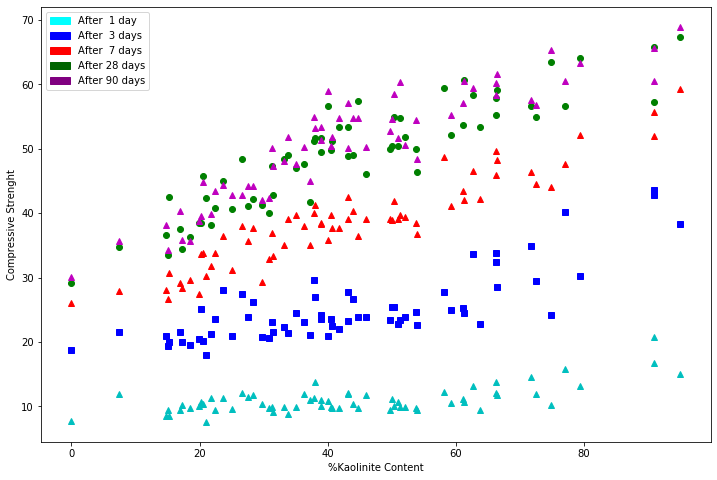

In [6]:
# Show points using matplotlib.pyplot library
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(x,y1,'c^',x,y3,'bs',x,y7,'r^',x,y28,'go', x90,y90,'m^')
plt.xlabel('%Kaolinite Content')
plt.ylabel('Compressive Strenght')

d1_patch  = mpatches.Patch(color='cyan',      label='After  1 day')
d3_patch  = mpatches.Patch(color='blue',      label='After  3 days')
d7_patch  = mpatches.Patch(color='red',       label='After  7 days')
d28_patch = mpatches.Patch(color='darkgreen', label='After 28 days')
d90_patch = mpatches.Patch(color='purple',    label='After 90 days')
plt.legend(handles=[d1_patch,d3_patch,d7_patch,d28_patch,d90_patch])

plt.show()

**First sight analysis:**

* **CS Day 1:** Almost constant, it curves from kaolinite content 50%, try degree two feature expansion.
* **CS Day 3:** Sparse points, we need to add another feature and maybe try also feature expansion.
* **CS Day 7:** The straight line is quite clear, we can try adding another feature for avoiding sparsification.
* **CS Day 28:** Straight line until 40% kaolinite content, then it curves. Feature expansion is needed as well as another feature for reducing sparsification.
* **CS Day 90:** Totally analogous than the day 28 data.


**Observations and next steps:**
* Maybe it would be interesting to have a predictor of the compression strength at 90 days (at time=infinity) knowing the compression strength before.
* In feature augmentation never go further than degree two, the curve is clearly always increasing.
* When having models involving only one or two features it's going to be important to plot for checking correctness.
* We have to search also mathematical measurements for the correctness of our models.

### Data correlation analysis

We have measures of 21 features/properties of the clays. Which are the (cor)relations among them? Which are the most important for predicting the compression strength? Are there redundancies?  We first try to answer this question by analyzing the correlations.

In [ ]:
# Function to hightlight high correlated cells in red
def highlight_high_correlations(cell):
    return 'background-color: %s' % ('red' if (cell != 1 and abs(cell) > CORRELATION_THRESHOLD) else 'white')

In [ ]:
# Correlation between clays properties themselves
CORRELATION_THRESHOLD = 0.6

corr_matrix = data.corr()[10:].iloc[:, 10:]
corr_matrix.style.applymap(highlight_high_correlations)

In [ ]:
# Correlation between Compression Strength measurements and clays properties
CORRELATION_THRESHOLD = 0.65

corr_matrix = data.corr()[10:].iloc[:, [0,2,4,6,8]]
corr_matrix.style.applymap(highlight_high_correlations)

In [ ]:
# Correlation between standard deviations of measurements and clays properties
CORRELATION_THRESHOLD = 0.2

corr_matrix = data.corr()[10:].iloc[:, [1,3,5,7,9]]
corr_matrix.style.applymap(highlight_high_correlations)

**First sight analysis:**

* Several important correlations between features, be aware of this when chosing features for our model to avoid redundancy.
* Compression strength can be predicted quite good with only the Kaolinite content, the relation is clear.
* At first sight there is no clear evidence of any feature being behind the standard deviation/variability of lc3.

# COMPRESSION STRENGTH (CS)

### Linear regression models

We have seen that the kaolinite content is the most predictive feature that we have. We are going to start creating simple linear regression models and then, following the appreciations obtained by visualizing the data, we are going to create non-linear models based on the kaolinite content for better fitting the data distribution as well as models with more features for avoiding data sparsification.

Two metrics are going to be extremely important here:
* **R square:** Is giving us a measurement of how good is our model (the closer to 1.0 the better). 
* **Validation score:** Is going to let us control overfitting. Improving R² means nothing if validation is worse. We'll use mean squared error with Leave One Out cross validation to estimate it.

#### Linear models based on the kaolinite content

In [ ]:
leave_one_out_validation(x.reshape(-1,1), y1)

In [ ]:
leave_one_out_validation(x.reshape(-1,1), y3)

In [ ]:
leave_one_out_validation(x.reshape(-1,1), y7)

In [ ]:
leave_one_out_validation(x.reshape(-1,1), y28)

In [ ]:
leave_one_out_validation(x90.reshape(-1,1), y90)

**First sight analysis:**

* There is few more we can improve at the 7th day using only the kaolinite content, data distribution is quite linear.
* For 1st and 3rd day the problem is more the sparsification of the points than the lack of expresivity of the model.
* For 28th and 90th day until 40% of kaolinite content the compression strength increases linearly and then estabilizes. Makes sense a non-linear model.
* It doesn't make sense in any model a degree 3 regression model, compression strength increases with kaolinite content.

#### Non-linear models based on the kaolinite content

In [ ]:
# x_2 = Kaolinite content, (Kaolinite content)^2
x_2   = np.array([x, x**2]).T
x90_2 = np.array([x90,x90*x90]).T 

In [ ]:
leave_one_out_validation(x_2, y1)

In [ ]:
leave_one_out_validation(x_2, y3)

In [ ]:
leave_one_out_validation(x_2, y7)

In [ ]:
leave_one_out_validation(x_2, y28)

In [ ]:
leave_one_out_validation(x90_2, y90)

**First sight analysis:**

* Expected results, better models obtained for 28th and 90th day compression strength obtained.
* We might be experiencing overfitting with this model for 1st and 3rd day measurements because we're not increasing the compressive strength with the increase of calonita for small contents.

### Feature selection

We have seen the importance and the clear relation of the Kaolinite conent with the compression strength and, we have seen also that the models involving only kaolinite content have their limitations (because of data sparsification). For achieving better results we have to add more modelation expressiveness by adding other variables to our model (new features or other artificially created) and, since the data distribution makes us think that linear regression models with the kaolinite content in degree three or more lead to overfitting, the best choice is adding new features.

Again, for avoiding overfitting with the few data we have we can't add several features so we have to decide well which is the best feature for complementing the kaolinite content. That's is the question we try to solve in this part.

In [7]:
# Which features are realiable? Those with more than RELIABLE_THRESHOLD measurements
RELIABLE_THRESHOLD = 45

features = data.columns[14:]
reliable_features = [f for f in features if data[f].describe()[0] >= RELIABLE_THRESHOLD]

In [8]:
# Show the reliable features, with enough points to rely
# reliable_features

In [9]:
# TODO: It would be nice to highlight maximums of R2 and minimums of MSE cells

In [ ]:
feature_selection(data, reliable_features)

In [ ]:
feature_selection(data, features, print_report=True)

#### Linear regression models based on the kaolinite content and other features

Following the results obtained in the feature selection part, here we are creating and analyzing the models done with the kaolinite conent (in degree one and two) as well as other features.

In [ ]:
# TODO:Create a function that given a feature and a day prints res.summary() or returns res

In [ ]:
# Day 1 
mod = smf.ols(formula='day_1 ~ Kaolinite_content + Kaolinite_content_square + Dv50', data=get_model_data(data, 'Dv50','1D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 1 
mod = smf.ols(formula='day_1 ~ Kaolinite_content + Kaolinite_content_square + CaO', data=get_model_data(data,'CaO','1D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 3
mod = smf.ols(formula='day_3 ~ Kaolinite_content + Kaolinite_content_square + Dv50', data=get_model_data(data,'Dv50','3D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 3
mod = smf.ols(formula='day_3 ~ Kaolinite_content + Kaolinite_content_square + CaO', data=get_model_data(data,'CaO','3D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 7
mod = smf.ols(formula='day_7 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data(data, 'BET_specific_surface','7D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 28
mod = smf.ols(formula='day_2 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data(data, 'BET_specific_surface','28D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 28
mod = smf.ols(formula='day_2 ~ Kaolinite_content + Kaolinite_content_square + TiO2', data=get_model_data(data, 'TiO2','28D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 90
mod = smf.ols(formula='day_9 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data(data, 'BET_specific_surface','90D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 90
mod = smf.ols(formula='day_9 ~ Kaolinite_content + Kaolinite_content_square + TiO2', data=get_model_data(data, 'TiO2','90D'))
np.random.seed(2)
res = mod.fit()
res.summary()

### Confidence analysis for the models

We know our model (function depending on the features provided) as well as some metrics to have an idea of how well our model fits our data (R2) and how is it behaving in practice with new data (MSE). The objetive of this section is to provide a more mathematical analysis of the confidence we can expect from our models.

#### Toy examples for putting things into practice

We are going to start with the Kaolinite content based model for compression strength at day 90 to exemplify the tools and techniques we can use to estimate confidence intervals in our model.

In [ ]:
# TODO: get_model_data should generalize this behavior for giving kaolinite in degree one and 2 and a given day

In [ ]:
data_28 = data[['Kaolinite_content', '28D']].copy()
data_28.insert(1, 'Kaolinite_content_square', data['Kaolinite_content']**2, True)
data_28 = data_28.dropna()
data_28.rename(columns = {'28D' : 'day_28'}, inplace = True)

In [ ]:
# Day 28
#mod = smf.ols(formula='day_28 ~ Kaolinite_content + Kaolinite_content_square', data=data_28)
#np.random.seed(2)
#res = mod.fit()
#res.summary()

In [ ]:
plot_confidence_intervals(data_28, 28)

In [ ]:
data_90 = data[['Kaolinite_content', '90D']].copy()
data_90.insert(1, 'Kaolinite_content_square', data['Kaolinite_content']**2, True)
data_90 = data_90.dropna()
data_90.rename(columns = {'90D' : 'day_90'}, inplace = True)

In [ ]:
# Day 90
#mod = smf.ols(formula='day_90 ~ Kaolinite_content + Kaolinite_content_square', data=data_90)
#np.random.seed(2)
#res = mod.fit()
#res.summary()

In [ ]:
plot_confidence_intervals(data_90, 90)

**First sight analysis:**

* We can't afford confidence intervals of such a high precission with such a lack of points, specially for high kaolinite contents.
* However, this worths a try after adding all the points from the second excel!

### References:

* How to deal with small datasets:\
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

* Feature engineering: \
https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

* Feature selection: \
https://en.wikipedia.org/wiki/Feature_selection \
https://machinelearningmastery.com/an-introduction-to-feature-selection/ \
https://machinelearningmastery.com/feature-selection-machine-learning-python/ \
https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/ \
https://machinelearningmastery.com/calculate-feature-importance-with-python/

* Linear regression with python: \
https://realpython.com/linear-regression-in-python/ 

* Confidence estimation: \
https://www.puneetarora2000.com/2020/01/data-interpretation-understanding-ols.html \
https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01 \
https://www.statsmodels.org/stable/regression.html \
https://www.datarobot.com/blog/ordinary-least-squares-in-python/ \
https://online.stat.psu.edu/stat415/lesson/7/7.5 \
https://tungmphung.com/confidence-intervals-for-linear-regression-coefficients/ \
https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

